# Q3: Are there characteristics of a country that correlate with increases or decreases in the use of nuclear energy?

Notebook to analyse correlations of nuclear energy usage with economic and political indicators.

In [1]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mplcursors
import country_converter
cc = country_converter.CountryConverter()

### Loading, Selection and Cleaning of Data

In [2]:
data = pd.read_csv('../data/data_merged/data.csv')
#data = clean_data_after_merge(data).set_index(['year','country']).sort_index()
data = data.set_index(['year','country']).sort_index()
data = data[
    [# economy
     'population','GDP','GDP growth', 'GDP per capita', 'GDP per capita growth',
     'income per capita', 'income per capita growth', 
     # political 
     'research_%GDP','representative_government', 'fundamental_rights',
     'checks_on_gouvernment', 'impartial_administration','civil_society_participation',
     'nuclear_warheads','accident_cost_MioUSD2013', 'accident_deaths',
     # nuclear energy 
     'built_reactors', 'shutdown_reactors', 'operating_reactors',
     'prod_btu', 'nuclear_prod_btu']
]

In [3]:
# function for cleaning, filtering and interpoation of missing values
def clean_data(data):
    data_cleaned = data.copy()
    
    # drop countries with many NaNs (more than 300 total)
    nans = data_cleaned.isna().sum(axis=1).sum(axis=0,level='country')
    countries = nans[nans<300].index 
    #excluded = nans[nans>=300].index
    #print('Excluded countries: ', cc.convert(excluded.to_list(), src='ISO3', to='short'))
    data_cleaned = data_cleaned.query('country in @countries')
    
    # fill production of nuclear energy with 0, if 'operating_reactors'==0 and 'nuclear_prod_btu'==NaN
    for year,country in data_cleaned.index:
        if (not data_cleaned['operating_reactors'].at[year,country].astype('bool')) and data['nuclear_prod_btu'].isna().at[year,country]:
            data_cleaned['nuclear_prod_btu'].at[year,country] = 0
    
    
    # interpolate per feature and country
    for column in data_cleaned.columns:
        if column in ['accident_cost_MioUSD2013','accident_deaths']: 
            data_cleaned[column] = data_cleaned[column].replace('No Accident',0)
        data_cleaned[column] = data_cleaned[column].unstack().interpolate().stack()
    
    return data_cleaned

data_cleaned = clean_data(data)

# print shapes and NAN-count
print('\nDATA: \t',data.shape, 'NANs:', data.isna().sum().sum(),
      '\nCLEANED:', data_cleaned.shape, 'NANs:', data_cleaned.isna().sum().sum())

<ipython-input-3-10a3e2f9d59a>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].unstack().interpolate().stack()



DATA: 	 (8502, 21) NANs: 33833 
CLEANED: (6942, 21) NANs: 15166


<ipython-input-3-10a3e2f9d59a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cleaned[column] = data_cleaned[column].replace('No Accident',0)


### How many humans live in counties that use nuclear energy? Was there a big change in the last 4 decades? Can we see a tendency of a correlation between the size of a nation (population) and if it uses nuclear energy? 

> One can see, that mostly big countries have operating nuclear power plants. Since the startup of the first reactor in China in 1991, more than half of the world's population live in countries that use nuclear energy. However, one can see that only a small fraction of all countries use nuclear power, because there are many small nations without reactors. 

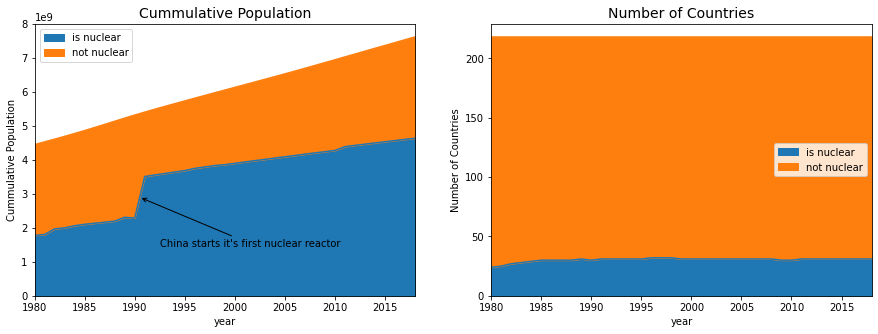

In [6]:
def plot_population_countries(data):  
    data['BOOL'] = (data['operating_reactors']>0)
    df = pd.DataFrame()
    df['is nuclear'] = data['population'][data['BOOL']].sum(level='year')
    df['not nuclear'] = data['population'][~data['BOOL']].sum(level='year')
    
    %matplotlib inline
    fig, ax = plt.subplots(1,2, figsize=[15,5])
    
    df.plot(kind='area', ax=ax[0])
    ax[0].set_ylabel('Cummulative Population')
    ax[0].set_xlim(df.index.min(),df.index.max())
    ax[0].set_title('Cummulative Population', fontsize=14)
    
    ycoord = 0.5 * (df.loc[1990,'is nuclear'] + df.loc[1991,'is nuclear'])
    ax[0].annotate(text = "China starts it's first nuclear reactor",
                   xy=(1990.5,ycoord),
                   xytext=(1990.5+2,ycoord*0.5),
                   ha='left', arrowprops=dict(arrowstyle='->'))

    df = pd.DataFrame()
    df['is nuclear'] = data['BOOL'].sum(level='year')
    df['not nuclear'] = (~data['BOOL']).sum(level='year')
    
    df.plot(kind='area', ax=ax[1])
    ax[1].set_ylabel('Number of Countries')
    ax[1].set_xlim(df.index.min(),df.index.max())
    ax[1].set_title('Number of Countries', fontsize=14)
    return None

plot_population_countries(data)

### Are there correlations between the use of nuclear energy and other properties (econimical and political) of a country?

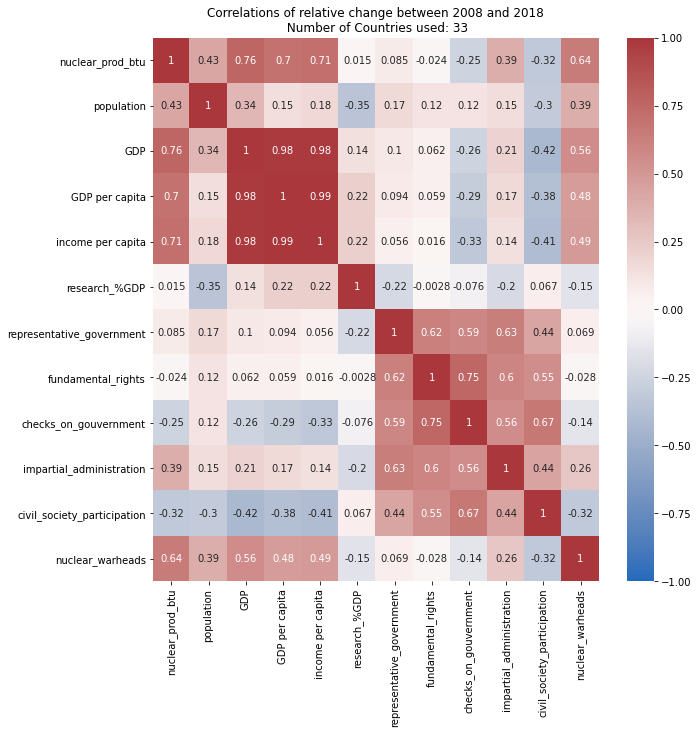

In [56]:
from sklearn.preprocessing import StandardScaler
def correlation_q3(data, start, end, nuclear_countries_only=True):
    # exclude countries, that do not use nuclear energy (in both year)
    if nuclear_countries_only:
        nuclear_countries = data.loc[[1998,2018],'operating_reactors'].sum(axis=0, level='country').replace(0,np.nan).dropna().index
        data = data.query("country in @nuclear_countries")
    df = data[['nuclear_prod_btu']+features]
    data_start = df.xs(start, level='year')
    data_end   = df.xs(end, level='year')
    data_quot  = (data_end.divide(data_start)-1).sort_index() # relative change
    
    # fill missing values with 0 and drop infinities
    data_quot = data_quot.fillna(0)
    data_quot = data_quot.replace(np.inf,np.nan).dropna()
    
    # transform data to interval [-1,1]
    scaler = StandardScaler()
    data_quot = pd.DataFrame(scaler.fit_transform(data_quot),
                            index=data_quot.index,
                            columns = data_quot.columns)
    
    # make plot
    %matplotlib inline
    plt.figure(figsize=[10,10])
    sns.heatmap(data_quot.corr(), vmin=-1, vmax=1, annot=True, cmap='vlag')
    plt.title(f'Correlations of relative change between {start} and {end}' + 
              f'\n Number of Countries used: {data_quot.index.size}')
    plt.show()
    
    return data_quot

test = correlation_q3(data,2008,2018, nuclear_countries_only=False)

In [41]:
test

,nuclear_prod_btu,population,GDP,GDP per capita,income per capita,research_%GDP,representative_government,fundamental_rights,checks_on_gouvernment,impartial_administration,civil_society_participation,nuclear_warheads
country,,,,,,,,,,,,
FRA,-0.626460,-0.792407,-0.898953,-0.865088,-0.879352,0.549558,0.615982,0.824448,0.641924,-0.389675,0.592356,-0.294982
GBR,-0.303419,-0.169437,-0.849821,-0.885859,-0.884168,0.507966,-0.167266,-0.357663,0.577731,1.402455,0.841545,-0.294982
IND,2.214933,0.636391,1.834138,1.944612,1.886487,-1.979490,0.604670,-0.501299,-1.563803,0.710330,-1.936667,2.197745
ISR,-0.528731,1.810715,0.688460,0.404266,0.488882,1.139874,-0.778486,1.822803,1.294651,-0.209978,0.897562,-0.294982
RUS,-0.229859,-1.270219,-0.794494,-0.713194,-0.785491,-0.424009,1.376343,-0.992789,-1.058702,0.289337,0.194193,-0.809948
USA,-0.526463,-0.215045,0.020671,0.115263,0.173642,0.206100,-1.651243,-0.795500,0.108198,-1.802470,-0.588989,-0.502850


### Are there correlations between the change of nuclear energy production and the change of other properties of a nation?

#### Compare data of two years (e.g. 1998 and 2018) and make scatterplots (for comparison of countries).

Compare relative change of following features with the relative change of nuclear energy production between two countries:

    population, GDP, GDP per capita, income per capita, research_%GDP, representative_government, fundamental_rights, checks_on_gouvernment, impartial_administration, civil_society_participation, nuclear_warheads
    
Although there can be seen no absolute tendencies, that are valid for most of the counties, the data of the different countries can be compared very well with the following function for plotting.

#### Usage of Plots:

`compare_years(data_cleaned,`**`feature(s) to plot, start year, end year`**`);`

By default, only the countries with nuclear reactors are shown (`nuclear_countries_only=True`). All countries are plotted, if this value is set to `False`, in case the data for the featue (y-axis) exists.

*To show the ISO3 code of the countires, click on a point (works as long as it is in 'interactive' mode). To hide ISO3 again, right-click on the text.*

In [4]:
def compare_years(data, features, start, end, nuclear_countries_only=True):
    # exclude countries, that do not use nuclear energy (in both year)
    if nuclear_countries_only:
        nuclear_countries = data.loc[[1998,2018],'operating_reactors'].sum(axis=0, level='country').replace(0,np.nan).dropna().index
        data = data.query("country in @nuclear_countries")
    if type(features)!=list: features = [features]
    df = data[features+['nuclear_prod_btu']]
    data_start = df.xs(start, level='year')
    data_end   = df.xs(end, level='year')
    data_quot  = (data_end.divide(data_start)-1).sort_index() # relative change
    
    # fill missing values
    data_quot['nuclear_prod_btu']  = data_quot['nuclear_prod_btu'].fillna(0)
    data_quot  = data_quot.fillna(-np.inf)
    
    # get continent information (for colorcode of scatterplots)
    data_quot['Continent'] = cc.convert(data_quot.index.get_level_values('country').to_list(), src='ISO3', to='continent')
    
    # scale down countries with large change in nuclear production
    max_quot_nuc_prod = data_quot[data_quot['nuclear_prod_btu']>2]['nuclear_prod_btu'].to_dict()
    data_quot.loc[max_quot_nuc_prod.keys(),'nuclear_prod_btu'] = 2
    
    # make interactive plot
    %matplotlib notebook
    %matplotlib notebook
    for feature in features:
        fig, ax = plt.subplots(figsize=[10,7])
        sns.scatterplot(data=data_quot, 
                x='nuclear_prod_btu', y=feature,
                hue='Continent', legend='full', ax = ax,
                palette={'Asia':'C0','Europe':'C1','Africa':'C2','America':'C3','Oceania':'C4','Antarctica':'C5'}
        )
        ax.set_title(feature.upper() + f', relative change from {start} to {end}')
        ax.set_xlabel('Nuclear Production, Relative Change')

        # Show ISO code of country when clicking
        mplcursors.cursor(multiple = True).connect(
            "add", lambda sel: sel.annotation.set_text(
                  data_quot.index[sel.target.index]
        ))

        # Add arrows for countries with large change in nuclear production (that were scaled down)
        for ISO3 in max_quot_nuc_prod.keys():
            ax.annotate(text=f'{max_quot_nuc_prod[ISO3]:.1f}',
                       xy=(2,data_quot.loc[ISO3,feature]),
                       xytext=(2.2,data_quot.loc[ISO3,feature]),
                       ha='left', va='center', arrowprops=dict(arrowstyle='<-', color='C0'))

        # Move Axes to centre, passing through (0,0)
        ax.spines['left'].set_position('zero')
        ax.spines['bottom'].set_position('zero')
        ax.spines['right'].set_color('none')
        ax.spines['top'].set_color('none')

        ax.legend(loc='best')
    plt.show()
    
    return data_quot

<IPython.core.display.Javascript object>


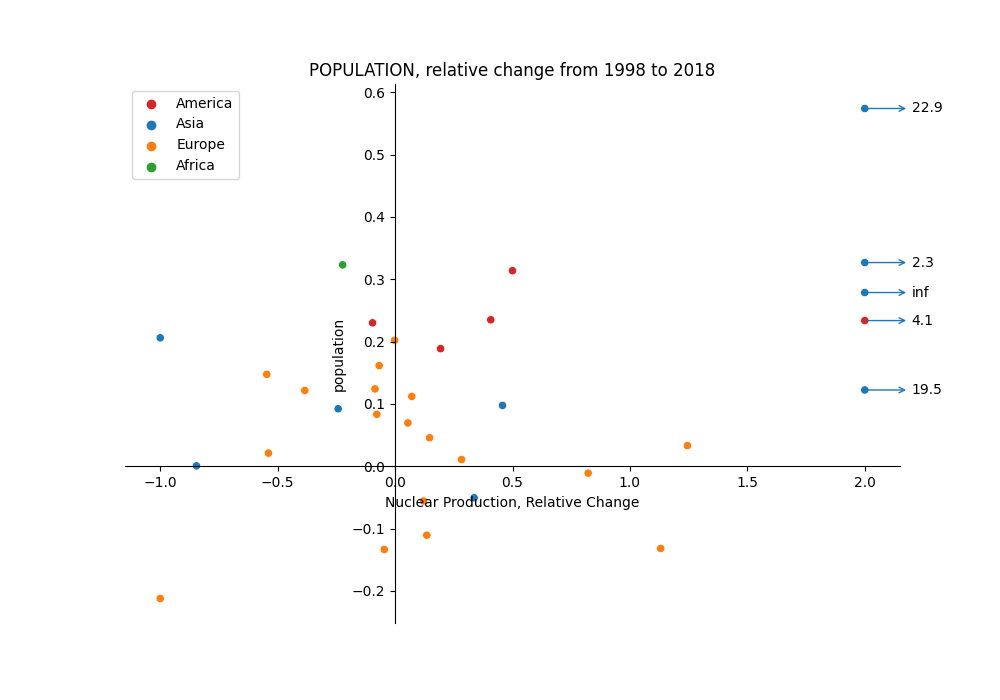

<IPython.core.display.Javascript object>


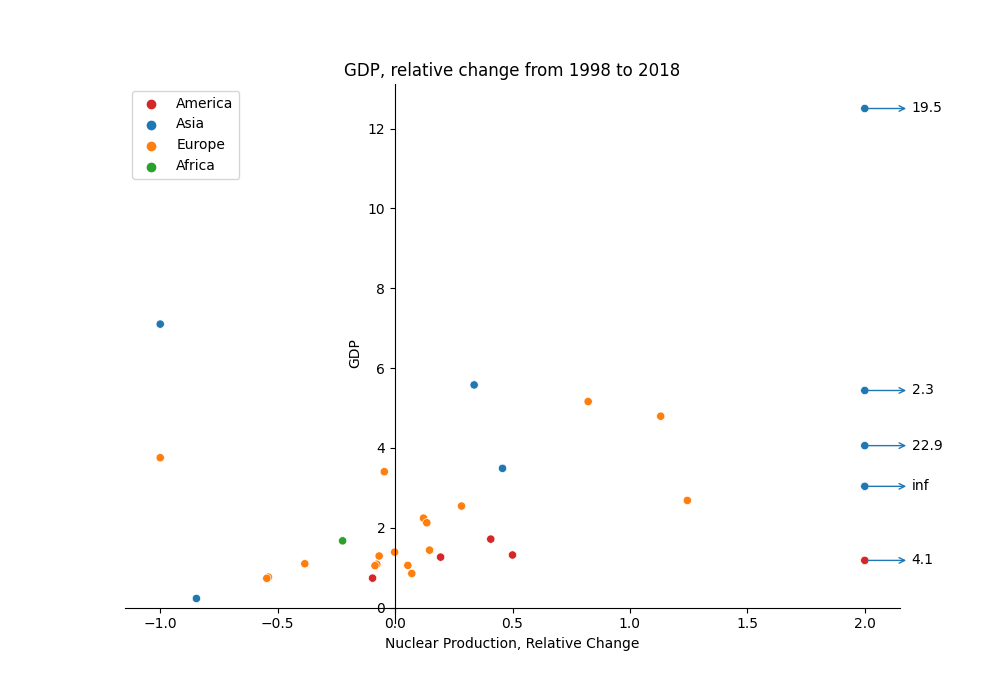

<IPython.core.display.Javascript object>


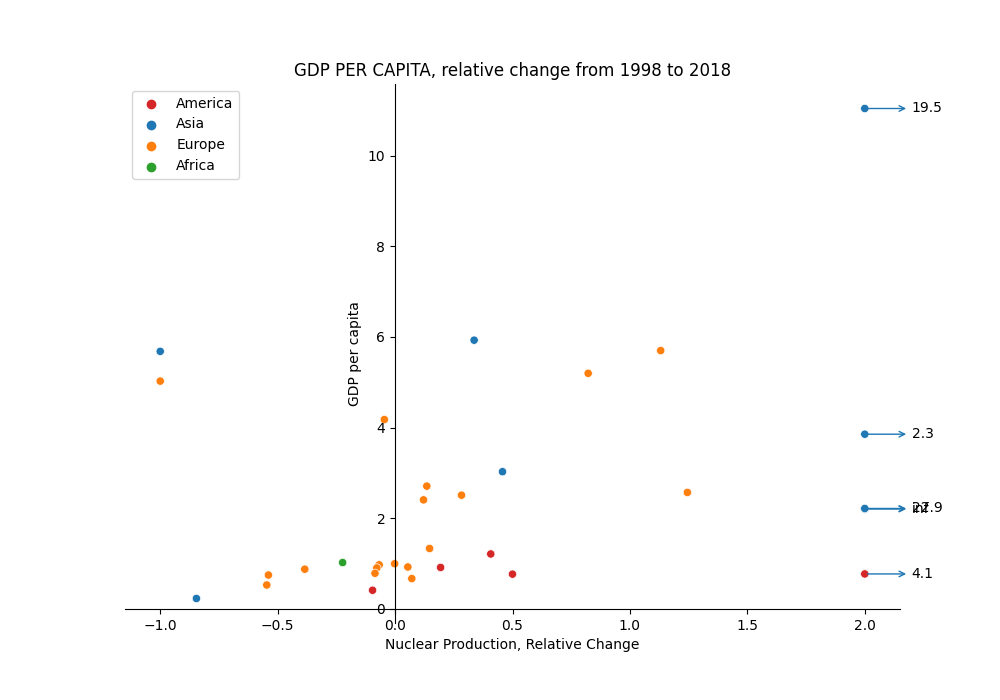

<IPython.core.display.Javascript object>


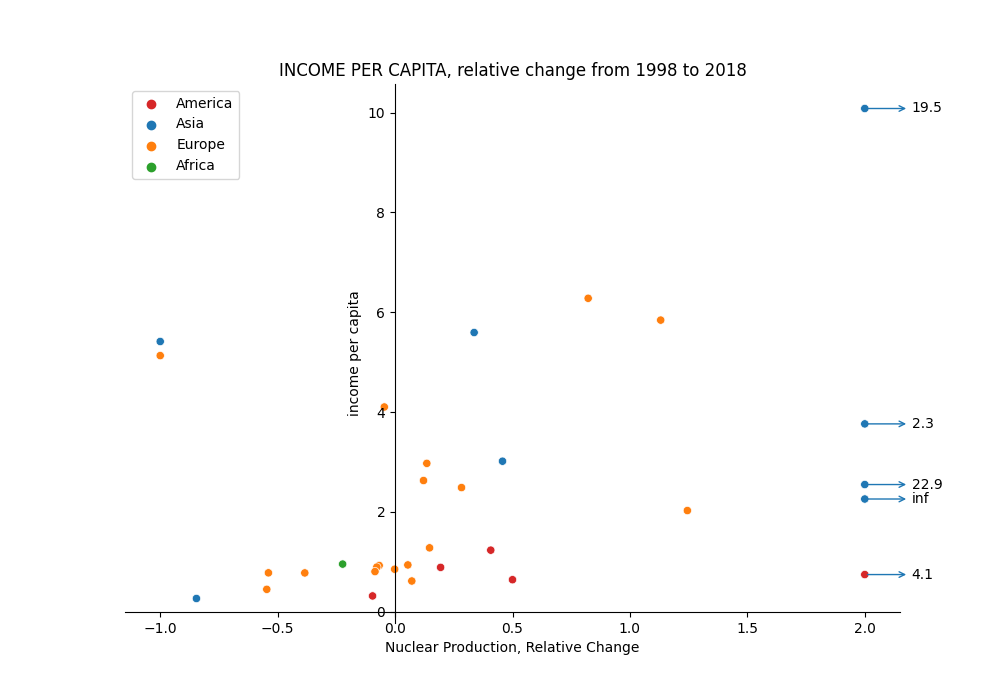

<IPython.core.display.Javascript object>


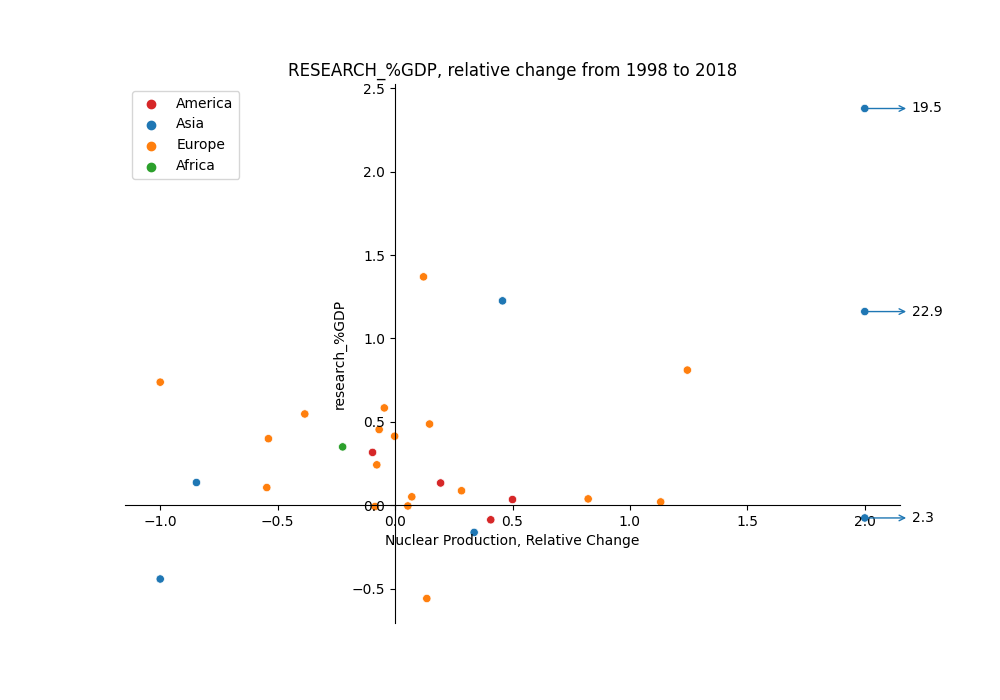

<IPython.core.display.Javascript object>


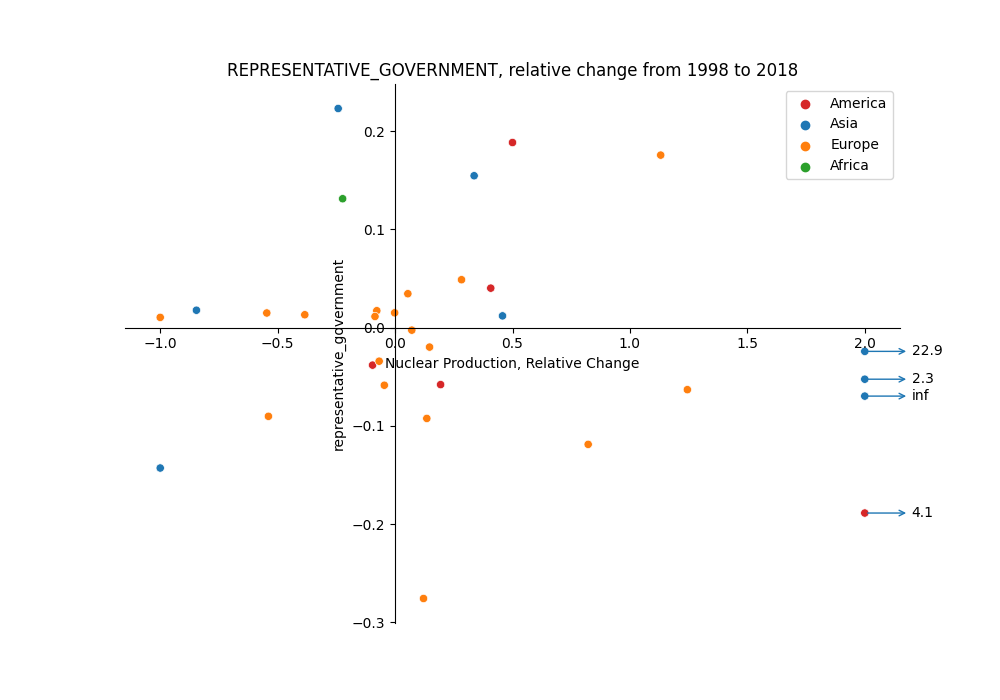

<IPython.core.display.Javascript object>


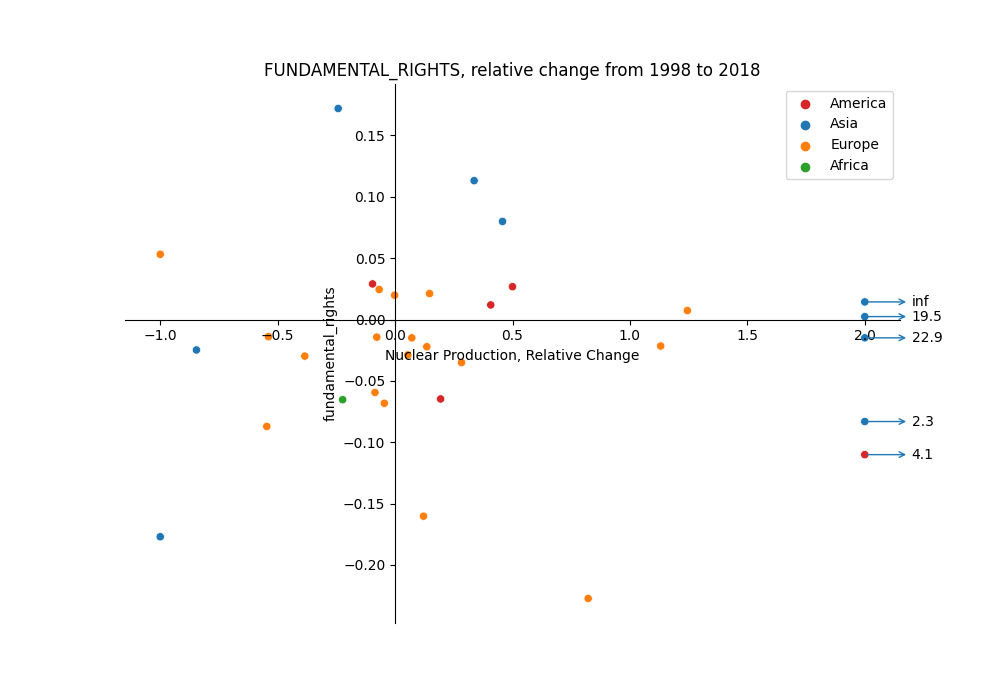

<IPython.core.display.Javascript object>


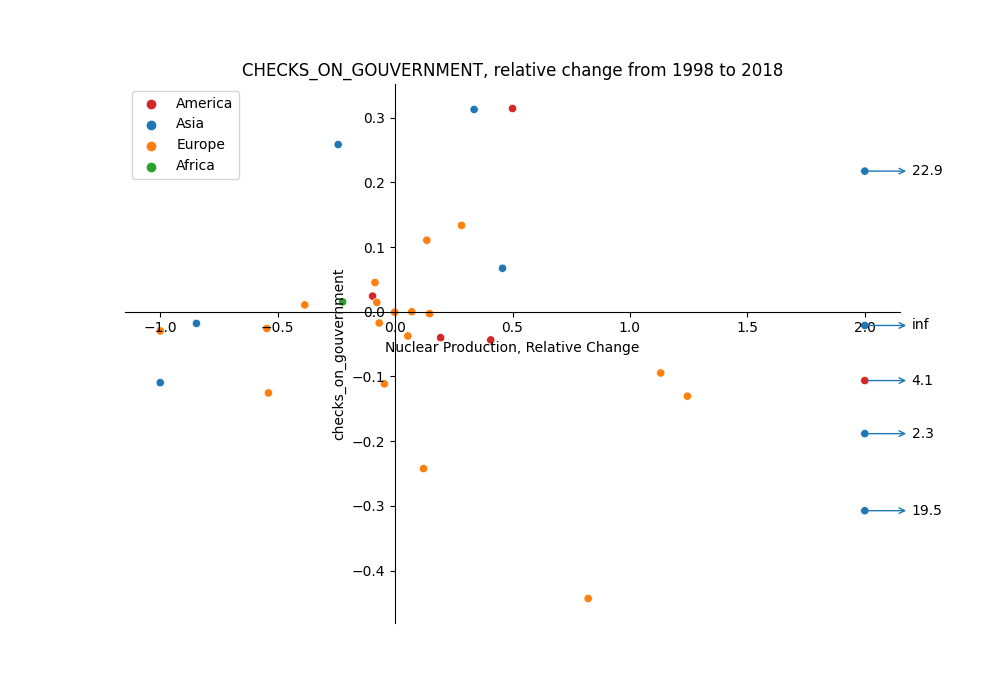

<IPython.core.display.Javascript object>


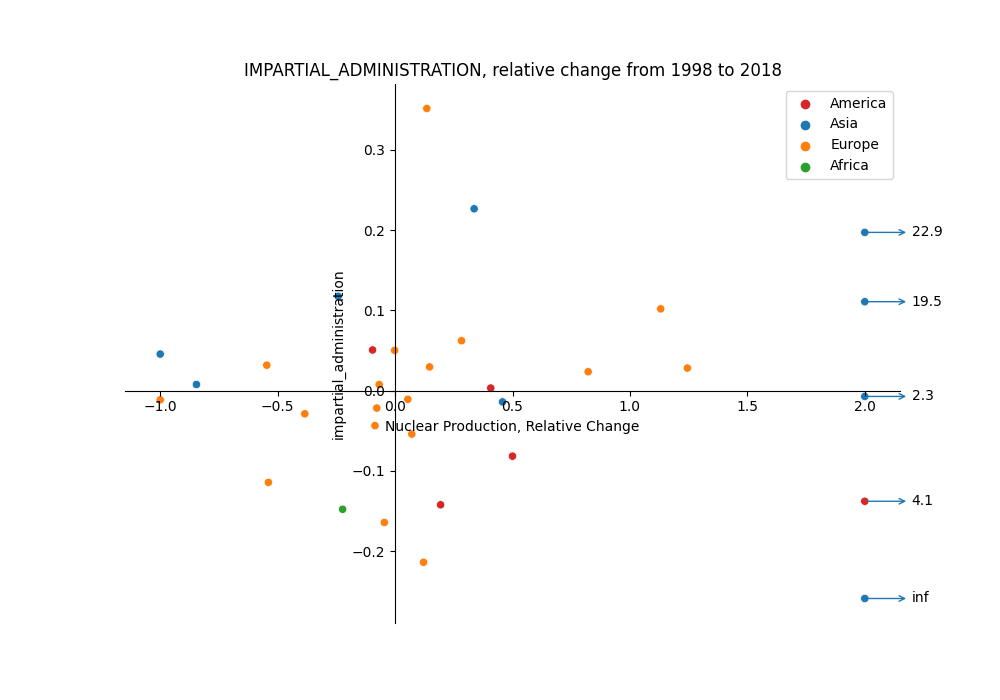

<IPython.core.display.Javascript object>


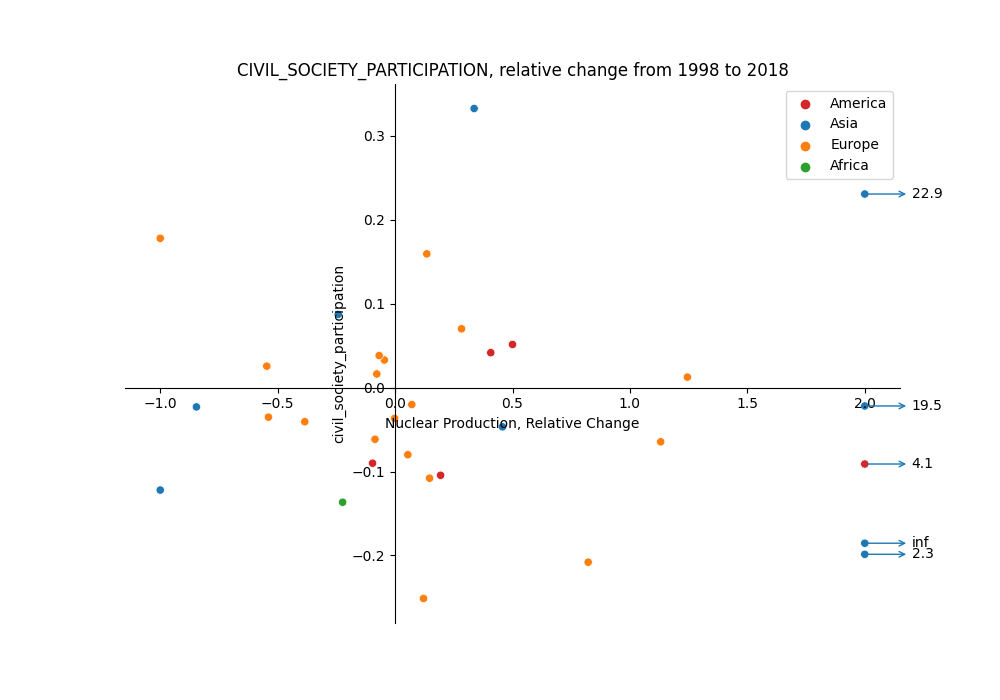

<IPython.core.display.Javascript object>


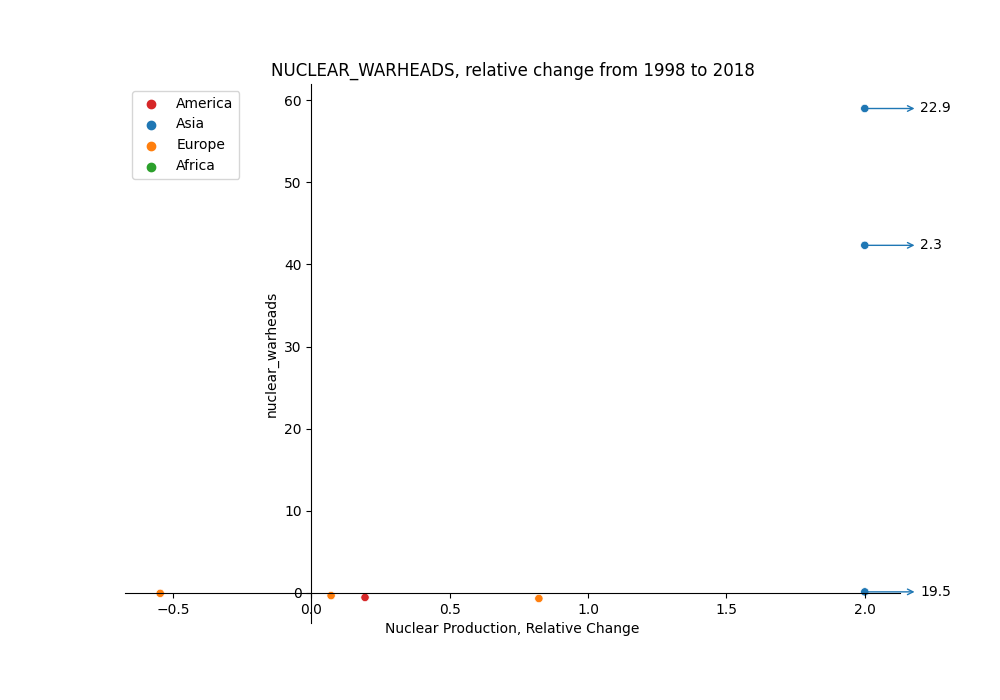

In [5]:
features = ['population','GDP','GDP per capita','income per capita','research_%GDP','representative_government','fundamental_rights',
                'checks_on_gouvernment','impartial_administration','civil_society_participation','nuclear_warheads']

test = compare_years(data_cleaned,features, 1998, 2018)

In [15]:
%matplotlib inline